In [8]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import logging
from src.database import PushDatabase
from src.data_loader import DataLoader
from config.constants import *

# Налаштування логування
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("🚀 Тестування системи аналізу push-сповіщень")
print("=" * 50)

ModuleNotFoundError: No module named 'src.database_config'

**КРОК 1: Перевірка підключень**

In [3]:
print("\n🔗 КРОК 1: ПЕРЕВІРКА ПІДКЛЮЧЕНЬ")
print("-" * 40)

db = DatabaseManager()
db.test_connections()


🔗 КРОК 1: ПЕРЕВІРКА ПІДКЛЮЧЕНЬ
----------------------------------------
🔍 Тестування підключень...
✅ Підключено до statistic
✅ Statistic: [(1,)]
✅ Підключено до keitaro
✅ Keitaro: [(1,)]


**КРОК 2: Базова перевірка структури БД**

In [4]:
print("\n🏗️ КРОК 2: СТРУКТУРА БАЗ ДАНИХ")
print("-" * 40)

# Statistic DB
print("\n📱 STATISTIC DB - Структура таблиць:")
try:
    stat_client = db.connect_statistic()
    tables = db.query_to_df(stat_client, "SHOW TABLES")
    print(f"Таблиці: {tables['name'].tolist()}")
    
    # Перевірити структуру event
    event_structure = db.query_to_df(stat_client, "DESCRIBE TABLE event")
    print(f"\n📋 Структура таблиці EVENT:")
    print(event_structure[['name', 'type']])
    
except Exception as e:
    print(f"❌ Помилка: {e}")

# Keitaro DB  
print("\n💰 KEITARO DB - Структура таблиць:")
try:
    keitaro_client = db.connect_keitaro()
    tables = db.query_to_df(keitaro_client, "SHOW TABLES")
    print(f"Таблиці: {tables['name'].tolist()}")
    
    # Перевірити структуру keitaro_clicks
    clicks_structure = db.query_to_df(keitaro_client, "DESCRIBE TABLE keitaro_clicks")
    print(f"\n📋 Структура таблиці KEITARO_CLICKS:")
    print(clicks_structure[['name', 'type']])
    
except Exception as e:
    print(f"❌ Помилка: {e}")


🏗️ КРОК 2: СТРУКТУРА БАЗ ДАНИХ
----------------------------------------

📱 STATISTIC DB - Структура таблиць:
Таблиці: ['device', 'device_with_date', 'event', 'event_backup', 'event_metrics_daily_aggregated', 'event_metrics_mv', 'event_trigger', 'postback_open', 'postback_open_with_date', 'temp_device', 'temp_event', 'temp_event_trigger', 'temp_postback_open']

📋 Структура таблиці EVENT:
              name            type
0               id            UUID
1        device_id  Nullable(UUID)
2       event_type           Int16
3   application_id           Int32
4             type            Int8
5       created_at        DateTime
6           fbclid          String
7            sub_1           Int32
8            sub_2          String
9            sub_3          String
10           sub_4           Int32
11           sub_5          String
12           sub_6           Int32
13           sub_7          UInt64

💰 KEITARO DB - Структура таблиць:
Таблиці: ['keitaro_affiliate_networks', 'keitaro_

 **КРОК 3:Швидка перевірка даних за період**

In [5]:
print(f"\n📊 КРОК 3: ПЕРЕВІРКА ДАНИХ ЗА ПЕРІОД")
print("-" * 40)

# Statistic - push-и за період
try:
    push_count_query = f"""
    SELECT 
        toDate(created_at) as date,
        COUNT(*) as push_count
    FROM event
    WHERE event_type = {PUSH_EVENT_TYPE}
      AND type = {ANDROID_TYPE}
      AND toDate(created_at) >= '{PUSH_START_DATE}'
      AND toDate(created_at) <= '{PUSH_END_DATE}'
    GROUP BY date
    ORDER BY date
    """
    
    push_daily = db.query_to_df(stat_client, push_count_query)
    print(f"\n📱 Push-и по днях (Android):")
    print(push_daily)
    
    total_pushes = push_daily['push_count'].sum()
    print(f"📊 Всього push-ів за період: {total_pushes:,}")
    
except Exception as e:
    print(f"❌ Помилка push-запиту: {e}")

# Keitaro - конверсії за період
try:
    conversion_count_query = f"""
    SELECT 
        date_key as date,
        COUNT(*) as total_clicks,
        SUM(is_sale) as deposits,
        SUM(is_lead) as registrations
    FROM keitaro_clicks
    WHERE date_key >= '{CONVERSION_START_DATE}'
      AND date_key <= '{CONVERSION_END_DATE}'
      AND sub_id_14 IS NOT NULL
    GROUP BY date_key
    ORDER BY date_key
    """
    
    conversion_daily = db.query_to_df(keitaro_client, conversion_count_query)
    print(f"\n💰 Конверсії по днях:")
    print(conversion_daily)
    
    total_deposits = conversion_daily['deposits'].sum()
    total_regs = conversion_daily['registrations'].sum()
    print(f"📊 Всього депозитів за період: {total_deposits:,}")
    print(f"📊 Всього реєстрацій за період: {total_regs:,}")
    
except Exception as e:
    print(f"❌ Помилка conversion-запиту: {e}")


📊 КРОК 3: ПЕРЕВІРКА ДАНИХ ЗА ПЕРІОД
----------------------------------------

📱 Push-и по днях (Android):
         date  push_count
0  2025-05-22    10476499
1  2025-05-23    13108492
2  2025-05-24    13248412
3  2025-05-25    13314369
4  2025-05-26    11694417
5  2025-05-27    14334217
6  2025-05-28    13388589
7  2025-05-29    11775005
📊 Всього push-ів за період: 101,340,000

💰 Конверсії по днях:
          date  total_clicks  deposits  registrations
0   2025-05-22        115012      3573          23752
1   2025-05-23        113573      3490          21622
2   2025-05-24         97753      2609          16826
3   2025-05-25        105055      2611          19072
4   2025-05-26        104851      2966          18477
5   2025-05-27        101967      2894          16491
6   2025-05-28         99429      2545          15375
7   2025-05-29         87826      1747          12248
8   2025-05-30         79393      1515          10416
9   2025-05-31         84698      1803          11956
10 

**КРОК 4: Візуалізація щоденної активності**


📈 КРОК 4: ВІЗУАЛІЗАЦІЯ АКТИВНОСТІ
----------------------------------------


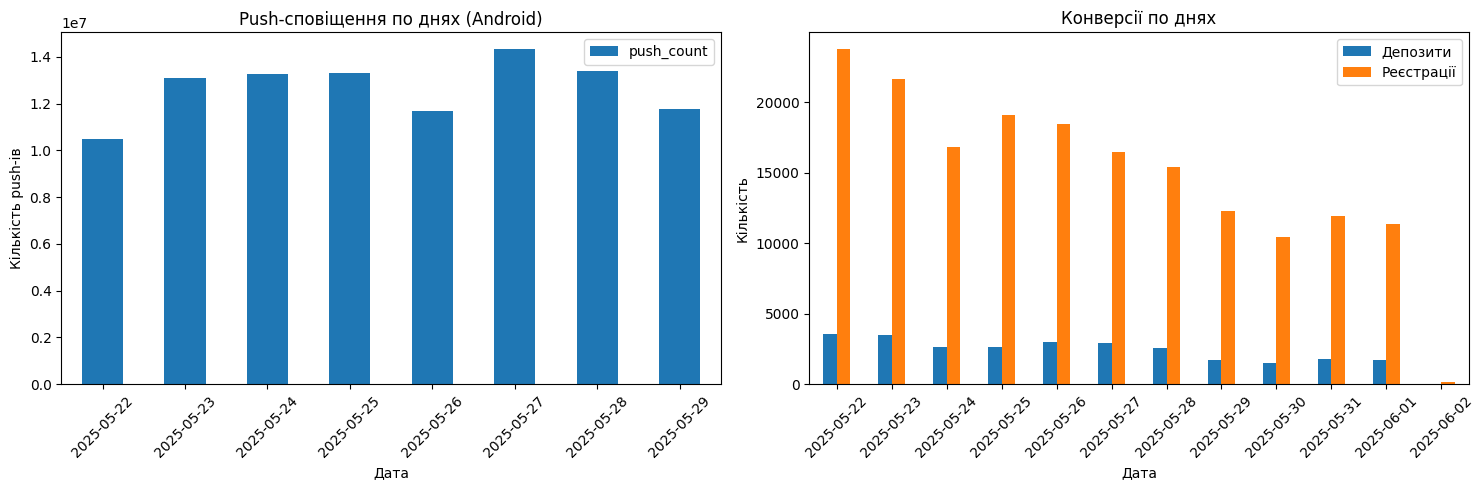

✅ Графік збережено: outputs/charts/daily_activity.png


In [6]:
print(f"\n📈 КРОК 4: ВІЗУАЛІЗАЦІЯ АКТИВНОСТІ")
print("-" * 40)

try:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Push-и по днях
    if not push_daily.empty:
        push_daily.plot(x='date', y='push_count', kind='bar', ax=axes[0])
        axes[0].set_title('Push-сповіщення по днях (Android)')
        axes[0].set_xlabel('Дата')
        axes[0].set_ylabel('Кількість push-ів')
        axes[0].tick_params(axis='x', rotation=45)
    
    # Конверсії по днях
    if not conversion_daily.empty:
        conversion_daily.plot(x='date', y=['deposits', 'registrations'], 
                            kind='bar', ax=axes[1])
        axes[1].set_title('Конверсії по днях')
        axes[1].set_xlabel('Дата')
        axes[1].set_ylabel('Кількість')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend(['Депозити', 'Реєстрації'])
    
    plt.tight_layout()
    plt.savefig('../outputs/charts/daily_activity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Графік збережено: outputs/charts/daily_activity.png")
    
except Exception as e:
    print(f"❌ Помилка візуалізації: {e}")

**КРОК 5: Попередні статистики**

In [7]:
print(f"\n📋 КРОК 5: ПОПЕРЕДНІ СТАТИСТИКИ")
print("-" * 40)

# A/B групи в push-даних
try:
    ab_groups_query = f"""
    SELECT 
        d.tag as ab_group,
        COUNT(DISTINCT d.gadid) as unique_users,
        COUNT(*) as total_pushes
    FROM event e
    JOIN device d ON e.device_id = d.id
    WHERE e.event_type = {PUSH_EVENT_TYPE}
      AND e.type = {ANDROID_TYPE}
      AND d.gadid IS NOT NULL
      AND d.tag IS NOT NULL
      AND toDate(e.created_at) >= '{PUSH_START_DATE}'
      AND toDate(e.created_at) <= '{PUSH_END_DATE}'
    GROUP BY d.tag
    ORDER BY ab_group
    """
    
    ab_stats = db.query_to_df(stat_client, ab_groups_query)
    print(f"\n🧪 A/B групи в push-даних:")
    print(ab_stats)
    
except Exception as e:
    print(f"❌ Помилка A/B запиту: {e}")

# Країни в push-даних
try:
    countries_query = f"""
    SELECT 
        d.country_name as country,
        COUNT(DISTINCT d.gadid) as unique_users,
        COUNT(*) as total_pushes
    FROM event e
    JOIN device d ON e.device_id = d.id
    WHERE e.event_type = {PUSH_EVENT_TYPE}
      AND e.type = {ANDROID_TYPE}
      AND d.gadid IS NOT NULL
      AND toDate(e.created_at) >= '{PUSH_START_DATE}'
      AND toDate(e.created_at) <= '{PUSH_END_DATE}'
    GROUP BY d.country_name
    ORDER BY unique_users DESC
    LIMIT 10
    """
    
    countries_stats = db.query_to_df(stat_client, countries_query)
    print(f"\n🌍 Топ-10 країн в push-даних:")
    print(countries_stats)
    
except Exception as e:
    print(f"❌ Помилка countries запиту: {e}")

print("\n" + "=" * 60)
print("✅ НАЛАШТУВАННЯ ТА ПЕРЕВІРКА ЗАВЕРШЕНА!")
print("🚀 Готово до переходу на EDA notebooks")
print("=" * 60)


📋 КРОК 5: ПОПЕРЕДНІ СТАТИСТИКИ
----------------------------------------

🧪 A/B групи в push-даних:
  ab_group  unique_users  total_pushes
0        1        619194       4913241
1        2        621206       9644140
2        3        620274      14158389
3        4        620457      18512086
4        5        622527      22735678
5        6            13           548

🌍 Топ-10 країн в push-даних:
                             country  unique_users  total_pushes
0                               None       1769093      44382456
1                          Argentina        471181      10714279
2                              India        100773       2229315
3                              Egypt         53209       1180425
4                         Bangladesh         40984        878651
5                             France         36936        881233
6                              Italy         32415        814870
7                         Kazakhstan         27744        680484
8  Venezuela